<a href="https://colab.research.google.com/github/AIREheart/Computational-Neuroscience/blob/main/assignments/syde552_assignment3_Hippocampal_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SYDE 552 Assignment 3: Hippocampal Models
### Due Monday, March, Anywhere on Earth
### Value: 15% of total marks for the course

The purpose of this assigment is to give you experience working with associative memories. To do so, we'll be using pytorch to implement different associative memory models.

You can work in groups to do the assignment, but your answers and code must be original to you. Your submission will be a filled-out copy of this notebook (cells for code and written answers provided).

# 1. The Hippocampus

**1.a) [2 marks]** The hippocampus is implicated in spatial navigation and episodic memory.  How do we know this?  What are some of the neuroscience results that revealed these facilities of the hippocampus?  (see Kandel *et al.* Ch. 65)

We know about the hippocampus's role in spatial navigation and episodic memory due to Patient HM and the removal of one of his hiccocampul lobes which resulted in his inability to form and retain any new long-term memories post surgery.

HM was able to learn new and complex tasks, but upon any slight distraction or loss of input stimulus he lost his ability to recall them. He, similar to other amensiacs, was able to perform similarly to healthy patients when given a task with priming but not with free recall.

Furthermore, spatial cognition is tied to the function of the hippocampus based on evidence that points towards the generation of cognitive maps; the obesrvance of place cells, which are neurons that fire with region-dependent specificity (a place field). In conjunction with activity with grid cells, which fire to provide positional insights to an organism by integrating motion into estimated locations.

**1.b) [2 marks]** The Gluck and Meyers model of hippocampus is a simple, effective model of hippocampus, and how representations may be constructed for the slow transfer to the neocortex.  However, it still has its limitations.  Explain some (two or more) of the limitations of the Gluck and Meyers model.  (The Gluck and Meyers Ch.6 reading will be useful in answering this question.)

Limitations of the Gluck and Meyers model include difficulty translating to domains other than instrumental conditioning and category learning such as spatial learning, declarative memory and delayed non-match to sample

1. Limited capacity (there is a limit to the memory capacity before the network produces nonuseful, nonsense outputs as a jarble of previously learned patterns). This doesn't correspond to biological processes since the brain is capable of learning new things and experiences an infinite amount of stimuli via new inputs.


2. This model does not make any particular attempt to address the
episodic memory deficits that are the most obvious feature of human hippocampal amnesia

3. Since this model operates on the basis of Hebbian learning (neurons that fire together, wire together), it faces difficulties in capturing delays or latencies between stimuli which may still be associated.

Finally, the model does not incorporate as much biological behavior when compared to the behavioral/memory-like model potential.

Sources: Gateway to Memory Chapter 6 (Gluck and Myers), PSYCHOBIOLOGICAL MODELS OF HIPPOCAMPAL FUNCTION IN LEARNING AND MEMORY <https://brainhealth.rutgers.edu/wp-content/uploads/2022/04/gluckmyers97.pdf> (Gluck and Myers)

**1.c) [2 mark]** Unsupervised pre-training is integral to the Gluck and Meyers model of Hippocampus, and unsupervised pre-training has been shown to accelerate reinforcement learning in rats navigating mazes.  However, unsupervised pre-training is not common in deep learning techniques.  Describe why that may be.  (See [$\S 15.1$ of Goodfellow *et al.*](https://www.deeplearningbook.org/contents/representation.html))

Unsupervised learning, also termed greedy layer-wise training, is much more computationally expensive as it involves independent optimization of the solution while keeping other elements fixed. It is a powerful tool to discover unknown patterns
Furthermore, it does not offer the ability to tune the model's regularization (and ability to over or underfit to the data) due to the isolated two-stage training, and it is based on hyperparameters that cannot adapt the regularization of. Instead, unsupervised learning may output results that are less interpretable/more subjective with less of a biological basis.

# 2. Hopfield Networks

## Preliminaries

Although you should have installed them for prior assignments, we will require the pytorch and keras. Let's install those now/

```pip install torch keras```

Next, we will download the MNIST dataset.  We will do this through the Keras library instead of torchvision.

Some people have been having problems with the code in the next block due to certificate errors.  If you do have this problem, try using the following code:

```python
import ssl
import keras.datasets.mnist
ssl._create_default_https_context = ssl._create_unverified_context
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
```

I don't recommend doing this if you don't have too - ignoring certificate errors is bad security practice.

In [ ]:
!pip install torch keras

import keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

As before, we will examine some of the images to make sure we got them right.

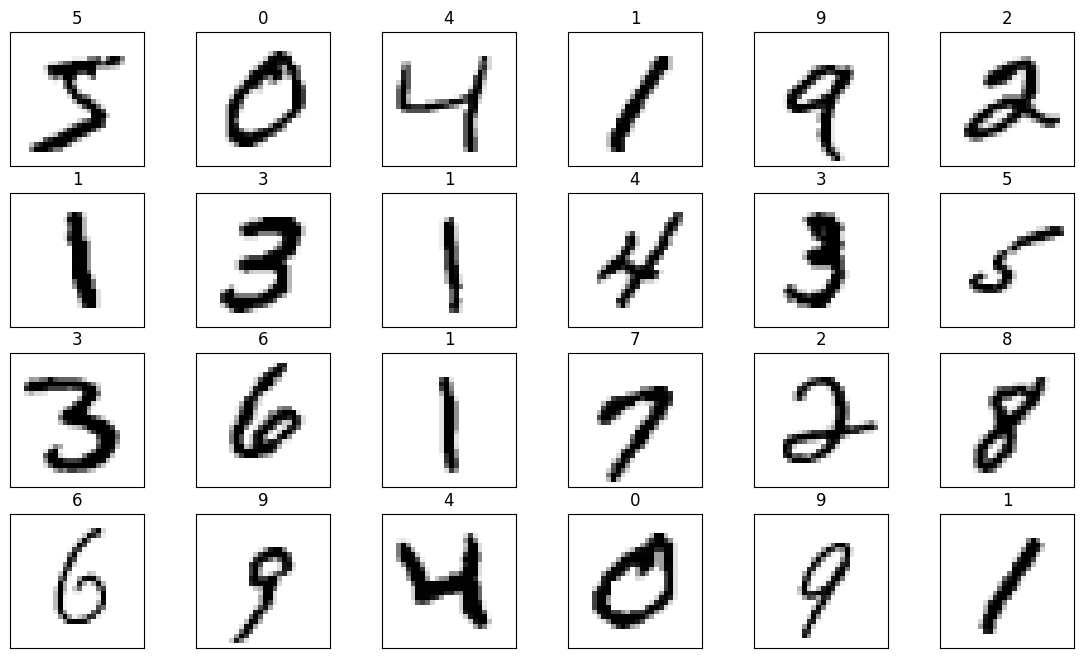

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(x_train[i].reshape((28,28)), vmin=0, vmax=255, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

Normally, the MNIST dataset has images represented by values in the range $[0,255]$. However, since we are dealing with Hopfield networks, we are going to binarize the data.

In [ ]:
def binarize(xs):
    '''
    xs : a num_samples by num_features array of images.
    '''
    binary = (xs / 255) > 0.5
    integer = 2 * binary - 1
    return integer


binary_imgs = binarize(x_train)


Further, to make things easy on our network, we are only going to look at images of the digits 0, 1, and 2

In [ ]:
binary_imgs = binary_imgs[y_train < 3,:]

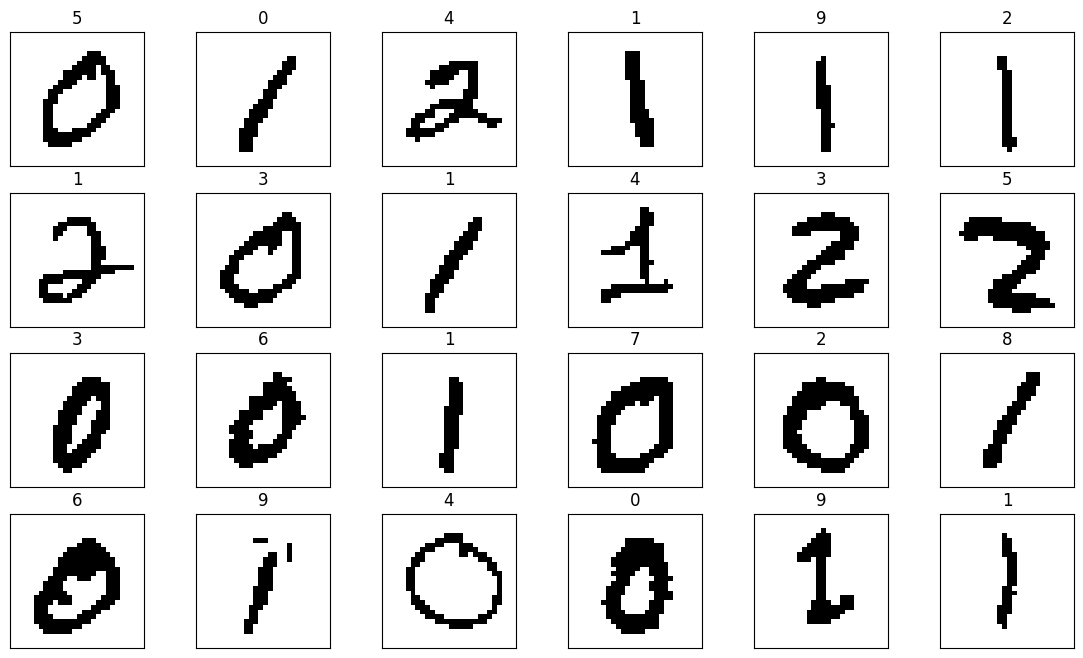

In [ ]:
plt.figure(figsize=(14,8))
for i in range(24):
    plt.subplot(4, 6, i+1)
    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.title(int(y_train[i]))

We will also need to reshape the data into a vector representation, and then covert it to a pytorch tensor

In [ ]:
import torch

binary_img_vecs = binary_imgs.reshape((-1,28*28))
binary_img_tensor = torch.from_numpy(binary_img_vecs).to(torch.float32)


**2.a) [2 Marks]**  Implement the Hopfield Network using Hopfield's learning rule.

We will first implement the Hopfield network using the outer product formulation for the weight matrix.  Given a set of patterns $\mathbf{x}_{i}$, by first computing the matrix

$$D = \frac{1}{N}\sum_{i}^{N} (\mathbf{x}_{i}-\theta)(\mathbf{x}_{i}-\theta)^T$$.

where $\theta = \frac{1}{ND}\sum_{i}^{N}\sum_{j}^{D} x_{i,j}$, i.e., the average value of all elements in the training data.

Next we remove the diagonal element of the matrix, making the weight matrix:

$$
W = D - \mathrm{diag}(D),
$$

where $\mathrm{diag}(D)$ is the diagonal of the $D$ matrix.  Note that when implementing this in numpy or pytorch we must apply the ```diag``` function twice, i.e.:

```
W = D - torch.diag(torch.diag(D))

```

Here is some code to implement the learning rule:

In [ ]:
import torch
def outer_product_hopfield_matrix(training_patterns):
    '''
    train_hopfield_matrix - produces a matrix for a (non-Modern) Hopfield network using the outer product rule.

    Parameters:
    -----------

    training_patterns : torch.Tensor

        A Tensor of shape (num_patterns, num_features) that will be used to construct the weight matrix.

    Returns:
    --------

    W : torch.Tensor

        A (num_features, num_features) Tensor that stores the papers encoded in the network.
    '''

    theta = torch.sum(training_patterns) / (training_patterns.shape[0] * training_patterns.shape[1])
    D = torch.einsum('nd,ne->de', training_patterns - theta, training_patterns - theta) / float(training_patterns.shape[0])
    W = (D - torch.diag(torch.diag(D)))
    return W

def evaluate_hopfield_network(W, input_pattern, training_patterns=None, num_iters = 5, threshold=0):
    '''
    Evaluates a Hopfield network with weight matrix W on a number of tets patterns.  Also computed the similarity
    '''

    assert input_pattern.shape[1] == 1, f'''This function assumes you are cleaning up one pattern at a time.
                                            Expected the input to be shape (1,{input_pattern.shape[1]}),
                                            got {input_pattern.shape}'''
    s = input_pattern

    similarities = None
    if training_patterns is not None:
        similarities = torch.zeros((num_iters, training_patterns.shape[0]))
    ### end if

    for i in range(num_iters):
        s = torch.sign(W @ s - threshold)

        if training_patterns is not None:
            similarities[i,:] = torch.einsum('d,nd->n',s,training_patterns)
        ### end if
    ### end for
    return s, similarities

We want you to do the following things:

1. Compute the capacity of the network, using the expression $C \approx \frac{d}{2\log_{2}(d)}$, where $d$ is the number of neurons.
2. For a training set of 10 patterns, plot the original image and the reconstructed image side-by-side.
3. Plot the training and test error (Mean squared error between the predicted and true values) of the Hopfield network as a function of the number of patterns stored in the network up to capacity, $C$, for five randomly selected training sets selected from ```binary_img_tensor```.
4. For a training set of size 10 patterns, add salt and pepper noise (bit flips) to the **testing** images and compute the testing error as the probability of noise increases.  Note: Compare the reconstructed images to the non-noisy images, e.g., for any test image you would do something like:

```python
noisy_image = corrupt(test_image, noise_level)
reconstructed_images = evaluate_hopfield_network(W, noisy_image.T)
error = mse(reconstructed_images, test_images)
```

In [ ]:
## 2.a.1 - Compute network capacity.

import numpy as np
d = 28*28
C = (d/(2*np.log2(d)))
print(f"The capacity of the network is {C}")


The capacity of the network is 40.770861144595855


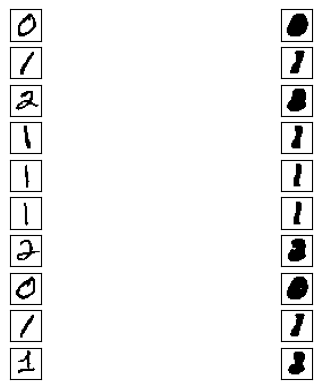

In [ ]:
# 2.a.2 - plot original and reconstructed imatges.
plt.figure()
# create weight matrix, W

W = []


for i in range(10):
    # reconstruct training image, i.
    W = outer_product_hopfield_matrix(binary_img_tensor)

    plt.subplot(10,2,1+2*i)
    # plot original image

    plt.imshow(binary_imgs[i].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(10,2,1+2*i+1)
    # plot reconstructed image.
    image = binary_imgs[i].reshape((1,-1)) # this will create a flattened image that is 1 x number of features (which in the case of MNIST is 28*28=784)
    reconstructed_image = torch.sign(W @ image.T)
    plt.imshow(reconstructed_image.reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    plt.xticks([])
    plt.yticks([])

In [ ]:
#print(reconstructed_image.reshape((28,28)))

index = np.random.choice(2000,40)
print(index)
training_idx = binary_img_tensor[:2000]
training_set = binary_img_tensor[index]
print(training_set)


[1079   27 1729  337 1275 1391  237   30  870  211  814  102 1545  800
 1402  281 1986   64  587 1727  101 1070 1816  776  292  468 1312 1379
  797 1584  251   31 1377  168  616  358 1400  119  223 1684]
tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])


[0.26020426 0.35204118 0.31326485 0.26632652 0.4224494  0.45714226
 0.40816277 0.5612256  0.4877549  0.5336731  0.3857139  0.4448982
 0.4234692  0.49591795 0.59693986 0.51836747 0.58673525 0.57244915
 0.5561224  0.5500009  0.54183733 0.489796   0.5724491  0.63469374
 0.52653    0.6744887  0.44081613 0.548981   0.64183617 0.6653056
 0.39183614 0.5459187  0.5704081  0.5326526  0.58061236 0.4551023
 0.6928586  0.6214296 ]
tensor([0.1990, 0.4133, 0.0000, 0.0459, 0.3878, 0.1888, 0.3163, 0.6480, 0.4592,
        0.6173, 0.5204, 0.4337, 0.7551, 0.6582, 0.6173, 0.3061, 0.6888, 0.7551,
        0.7449, 0.5459, 0.6531, 0.7143, 0.8418, 0.4796, 0.4337, 0.6939, 0.4082,
        0.4541, 0.8214, 0.5765, 0.2806, 0.5969, 0.6224, 0.6786, 0.2959, 0.7347,
        0.6939, 0.5663])
tensor([0.1990, 0.4133, 0.0000, 0.0459, 0.3878, 0.1888, 0.3163, 0.6480, 0.4592,
        0.6173, 0.5204, 0.4337, 0.7551, 0.6582, 0.6173, 0.3061, 0.6888, 0.7551,
        0.7449, 0.5459, 0.6531, 0.7143, 0.8418, 0.4796, 0.4337, 0.6939, 

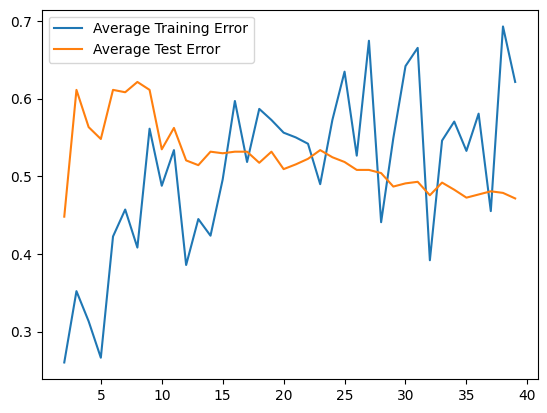

In [ ]:
# 2.a.3 - Plot training and test error
#Plot the training and test error (Mean squared error between the predicted and true values)
#of the Hopfield network as a function of the number of patterns stored in the network up to capacity,  C ,
#for five randomly selected training sets selected from binary_img_tensor.

def mse(true_val, pred_val):
    assert torch.is_tensor (true_val)
    assert torch.is_tensor (pred_val)
    #assert torch.mean((true_vals - pred_val)**2)

    return torch.mean((pred_val - true_val)**2)

test_set = binary_img_tensor[-10:]

all_training_error = []
all_test_error = []

for trial in range(5):


    index = np.random.choice(2000,40)
    training_set = binary_img_tensor[index]
    training_error = torch.zeros((len(range(2,int(np.floor(C)))),))
    test_errors = torch.zeros((len(range(2,int(np.floor(C)))),))

    for i, num_patterns in enumerate(range(2,int(np.floor(C)))):
        W = outer_product_hopfield_matrix(training_set[:num_patterns])
        errors = []  #per image

        for img in training_set[:num_patterns]:
            X = training_set[:num_patterns].reshape((num_patterns, -1))
            reconstructed_image = torch.sign(W @ img.T).reshape((1,-1))
            #errors.append(mse(reconstructed_image, img.reshape((1,-1))))
            assert img is not None
            assert reconstructed_image is not None

            training_error[i] = torch.mean(mse(reconstructed_image, img))


        for img in test_set:
            reconstructed_image = torch.sign(W @ img.T)
            #errors.append(mse(reconstructed_image, img))
            test_errors[i] = torch.mean(mse(reconstructed_image, img))

        all_training_error.append(training_error)
        all_test_error.append(test_errors)

average_error = np.mean(all_training_error, axis=0)
average_test_error = np.mean(all_test_error, axis=0)
print(average_error)
print(all_training_error[0])
print(all_training_error[1])

plt.figure()
plt.plot(range(2,int(np.floor(C))), average_error, label = 'Average Training Error')

plt.plot(range(2,int(np.floor(C))), average_test_error, label = 'Average Test Error')
plt.legend()


tensor([0.0100, 0.0644, 0.1189, 0.1733, 0.2278, 0.2822, 0.3367, 0.3911, 0.4456,
        0.5000])
tensor(0.0100)
tensor(0.0644)
tensor(0.1189)
tensor(0.1733)
tensor(0.2278)
tensor(0.2822)
tensor(0.3367)
tensor(0.3911)
tensor(0.4456)
tensor(0.5000)
the mses are: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        1.0520])


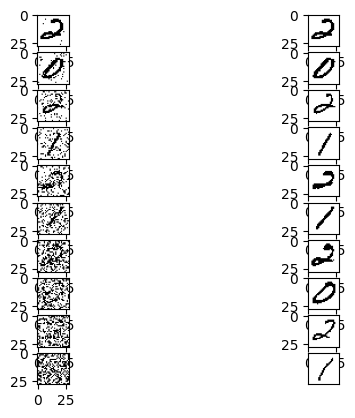

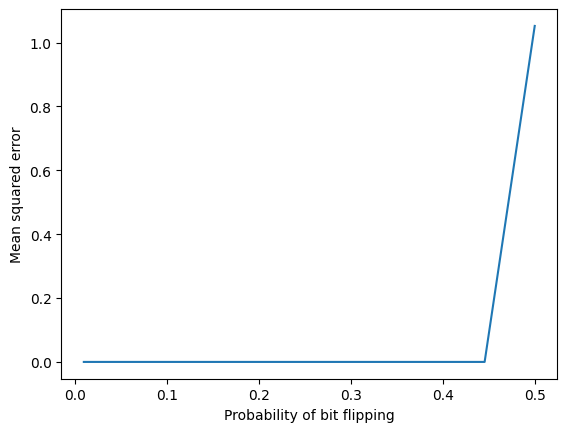

In [ ]:
# 2.a.4 - Test salt-and-pepper noise.
#For a training set of size 10 patterns, add salt and pepper noise (bit flips)
#to the testing images and compute the testing error as the probability of noise
#increases. Note: Compare the reconstructed images to the non-noisy images, e.g.,
#for any test image you would do something like:

num_steps = 10 ### Pick a value
prob_flip = torch.linspace(0.01,0.5,num_steps)
print(prob_flip)
training_data = training_set[:10]

testing_data = test_set

all_mses = []
W = outer_product_hopfield_matrix(training_data)
for p_idx, p in enumerate(prob_flip):
    mses = torch.zeros(len(range(0, 10)))
   # for img in testing_data:
    index = np.random.choice(784,int(784*p))
    img = testing_data.clone()

    image = img[p_idx]


    img[p_idx, index] = -1 * img[p_idx,index].reshape((1,-1))
    reconstructed_image = torch.sign(W @ img.T)


    mses[p_idx] = torch.mean(mse(reconstructed_image, image[p_idx]))



    print(p)
    plt.subplot(10,2,2*p_idx+1)

    plt.imshow(img[p_idx].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

    plt.subplot(10,2,2*(p_idx+1))

    plt.imshow(testing_data[p_idx].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

    pass

plt.xticks([])
plt.yticks([])
print(f"the mses are: { mses}")
plt.figure()
plt.xlabel('Probability of bit flipping')
plt.ylabel('Mean squared error')
plt.plot(prob_flip, mses)

**2.b) [2 Mark]** Train Hopfield network using the pseudo-inverse and repeat the tasks 2.a) 2-4, however, for this example, ensure the threshold value is 0.  Even though the pseudo-inverse has a greater capacity thant he hopfield network, we will still test up to the theoretical capcity of the Hopfield learning rule.

[0.08163262 0.07755115 0.09999985 0.12142862 0.14489782 0.15510198
 0.19285703 0.20204076 0.27346954 0.60203993 0.61122376 0.8285717
 0.7183672  0.8877554  0.8540824  1.0163246  1.4091831  1.0724484
 1.0551031  1.0938781  1.1316324  1.4734693  1.7897962  1.138774
 1.7030599  1.4499997  1.2275519  1.7785689  1.4938804  2.215306
 1.7224498  1.8785722  1.5724522  1.4275534  1.9112252  1.1918347
 1.7826568  1.7642885  1.3622462 ]
tensor([0.0816, 0.0867, 0.1071, 0.1378, 0.1735, 0.1939, 0.2551, 0.1939, 0.2602,
        0.2398, 0.3061, 0.3929, 0.3673, 0.3827, 0.4439, 0.7653, 1.0255, 0.8724,
        0.9898, 0.9031, 1.2041, 1.1939, 1.4133, 1.1735, 2.5816, 2.2194, 1.1276,
        2.6633, 1.1990, 2.7806, 2.7551, 2.9541, 1.1327, 1.1939, 1.4388, 1.1224,
        2.9439, 2.5102, 1.2602])
tensor([0.0816, 0.0867, 0.1071, 0.1378, 0.1735, 0.1939, 0.2551, 0.1939, 0.2602,
        0.2398, 0.3061, 0.3929, 0.3673, 0.3827, 0.4439, 0.7653, 1.0255, 0.8724,
        0.9898, 0.9031, 1.2041, 1.1939, 1.4133, 1.1735, 2

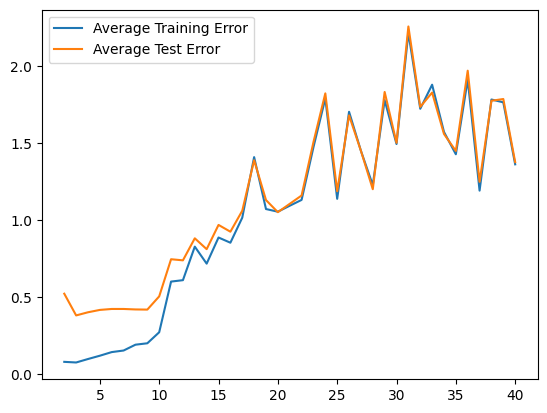

In [ ]:
def pseudo_inv(X, lamb=0.01):
    '''
    pseudo_inv - Implements the pseudoinverse from the previous assignment.

    Parameters:
    -----------

    X : torch.Tensor
        A (num_patterns, num_features) Tensor holding the training data.

    lamb : float
        The regularization term for the pseudoinverse


    Returns:
    --------

    The pseudoinverse of X
    '''
    return torch.inverse(X.T@X + lamb * torch.eye(X.shape[1]).float()) @ X.T

def pseudoinverse_hopfield_matrix(training_patterns, lamb = 0.01):
    '''
    pseudoinverse_hopfield_matrix - Uses the regularized pseudoinverse to construct a weight matrix for
        a non-modern Hopfield network.

    Parameters:
    -----------

    training_patterns : torch.Tensor

        The (num_patterns, num_features) Tensor containing the training data.

    lamb : float

        The regularization term for the pseudo-inverse.

    Returns:
    --------

        The weight matrix compatible with the evaluate_hopfield_network function
    '''
    W = pseudo_inv(training_patterns, lamb=lamb) @ training_patterns
    return W / training_patterns.shape[0]



# 2.a.3 - Plot training and test error
#Plot the training and test error (Mean squared error between the predicted and true values)
#of the Hopfield network as a function of the number of patterns stored in the network up to capacity,  C ,
#for five randomly selected training sets selected from binary_img_tensor.

def mse(true_val, pred_val):
    assert torch.is_tensor (true_val)
    assert torch.is_tensor (pred_val)
    return torch.mean((pred_val - true_val)**2)

test_set = binary_img_tensor[-10:]

all_training_error = []
all_test_error = []

for trial in range(5):


    index = np.random.choice(2000,40)
    training_set = binary_img_tensor[index]
    training_error = torch.zeros((len(range(2,int(np.floor(C+1)))),))
    test_errors = torch.zeros((len(range(2,int(np.floor(C+1)))),))

    for i, num_patterns in enumerate(range(1,int(np.floor(C)))):
        W = pseudoinverse_hopfield_matrix(training_set[:num_patterns])
        errors = []  #per image

        for img in training_set[:num_patterns]:
            X = training_set[:num_patterns].reshape((num_patterns, -1))
            reconstructed_image = torch.sign(W @ img.T)#.reshape((num_patterns,-1))
            assert img is not None
            assert reconstructed_image is not None

            training_error[i] = torch.mean(mse(reconstructed_image, img))


        for img in test_set:
            reconstructed_image = torch.sign(W @ img.T)
            #errors.append(mse(reconstructed_image, img))
            test_errors[i] = torch.mean(mse(reconstructed_image, img))

        all_training_error.append(training_error)
        all_test_error.append(test_errors)

average_error = np.mean(all_training_error, axis=0)
average_test_error = np.mean(all_test_error, axis=0)

print(average_error)
print(all_training_error[0])
print(all_training_error[1])

plt.figure()
plt.plot(range(2,int(np.floor(C+1))), average_error, label = 'Average Training Error')

plt.plot(range(2,int(np.floor(C+1))), average_test_error, label = 'Average Test Error')
plt.legend()


**2.c) [1 Mark]** Show how the network behaves when an entire region of the image is corrupted.

For your best performing network, take three test images and set half of the inputs to be equal to zero.  
Plot the original images, the corrupted images, and the reconstructed images, side-by-side.

tensor([[-0., -0., -0.,  ..., -0., -1., -0.],
        [-1., -0., -1.,  ..., -1., -1., -1.],
        [-1., -1., -0.,  ..., -0., -1., -1.]])


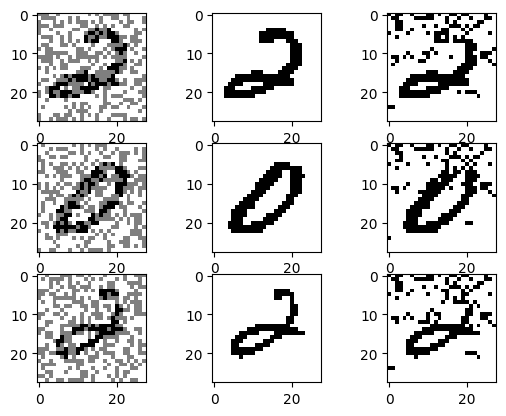

In [ ]:
# Your code here

#pseudoinverse is best performing network

index = np.random.choice(784,392)
img = test_set[:3]
corrupted = img.clone()
corrupted[0,index] = 0 * corrupted[0,index]

index = np.random.choice(784,392)
corrupted[1,index] = 0 * corrupted[1,index]
index = np.random.choice(784,392)

corrupted[2,index] = 0 * corrupted[2,index]



print(corrupted)
plt.subplot(3,3,1)
plt.imshow(corrupted[0].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
plt.subplot(3,3,2)
plt.imshow(img[0].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')


plt.subplot(3,3,4)
plt.imshow(corrupted[1].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
plt.subplot(3,3,5)
plt.imshow(img[1].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

plt.subplot(3,3,7)
plt.imshow(corrupted[2].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
plt.subplot(3,3,8)
plt.imshow(img[2].reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')

W = pseudoinverse_hopfield_matrix(test_set)
c = 1
for img in corrupted:
    X = test_set#.reshape((num_patterns, -1))
    reconstructed_image = torch.sign(W @ img.T)#.reshape((num_patterns,-1))
    assert img is not None
    assert reconstructed_image is not None
    plt.subplot(3,3,3*c)
    plt.imshow(reconstructed_image.reshape((28,28)), vmin=-1, vmax=1, cmap='gray_r')
    c+=1



#Column 1 = corrupted images
#Column 2 = original images
#Column 3 = reconstructed images


# 3. Autoencoders

Now we are going to train an autoencoder to perform the same associative task that we explored above.  We are going to define our Autoencoder using sigmoid neurons, which shouldn't be too terrible, since it is a relatively shallow network, but one is not obligated to use those.

Because we are going to use a sigmoidal output function, so we should be concerned with values in the range $[0,1]$, instead of $\{-1,1\}$.  Training will be done using the original MNIST images, **not** the binary images.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

x_train_tensor = torch.from_numpy(x_train.reshape((-1,28*28)).astype(np.float32) / 255)
x_test_tensor = torch.from_numpy(x_test.reshape((-1,28*28)).astype(np.float32) / 255)

train_dataset = TensorDataset(x_train_tensor, x_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

test_dataset = TensorDataset(x_test_tensor, x_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=True)

In [ ]:
class Autoencoder(torch.nn.Module):
    def __init__(self, num_inputs, num_hidden):
        super().__init__()

        # Building an linear encoder with Linear
        # layer followed by Sigmoid activation function
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(num_inputs, num_hidden),
            torch.nn.Sigmoid(),
        )

        # Building an linear decoder with Linear
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(num_hidden, num_inputs),
            torch.nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

def continue_training():
    network.train()      # configure the network for training
    for i in range(10):  # train the network 10 times
        epoch_loss = []
        for data, target in train_loader:       # working in batchs of 1000
            optimizer.zero_grad()               # initialize the learning system
            output = network(data)              # feed in the data
            loss = F.mse_loss(output, target)   # compute how wrong the output is
            loss.backward()                     # change the weights to reduce error
            optimizer.step()                    # update the learning rule
            epoch_loss.append(loss.detach().numpy())


    # update the list of training accuracy values
    training_loss.append(np.mean(epoch_loss)) # store the loss for later.
    print('Iteration', len(training_loss), 'Training loss:', training_loss[-1])

    correct = 0
    network.eval()
    test_set_loss = []
    for data, target in test_loader:    # go through the test data once (in groups of 1000)
        output = network(data)                               # feed in the data
        loss = F.mse_loss(output, target)
        test_set_loss.append(loss.detach().numpy())


    # update the list of testing accuracy values
    testing_loss.append(np.mean(test_set_loss))
    print('Iteration', len(testing_loss), 'Testing accuracy:', testing_loss[-1])

**3.1 [2 Marks]** For the autoencoder we will do the following:

1. Train the network and plot the testing and training losses(repeated trials) for 5 different different values of the hidden layer size.  **Ensure the number of hidden layers is always less than the number of input features**.  Select a good number of training iterations (i.e., not overfitting) and a good number of hidden neurons
2. Plot 10 input and reconstructed images from the training set and 10 from the testing set.  How do these compare to the reconstructions of from the Hopfield networks you constructed above?
3. With your trained network, compare the loss on inputs corrupted salt and pepper noise.  Sweep through a range of number of pixels corrupted from 0 to 75\%.  Because the image data is back in the range $[0,1]$, this time corrupt the image by setting pixels to equal 0 or 1 with 50\% probability.

In [ ]:
network = Autoencoder(784,10) ## Create the autoencoder here

training_loss = []
testing_loss = []

# We're all hip, fashionable people here, let's use the Adam optimizer.
optimizer = torch.optim.Adam(network.parameters(), lr = 1e-5)

for i in range(10):
    continue_training()
    training_loss[i] = training_loss[-1]
    testing_loss[i] = testing_loss[-1]



Iteration 1 Training loss: 0.23361884
Iteration 1 Testing accuracy: 0.23340443
Iteration 2 Training loss: 0.22820705
Iteration 2 Testing accuracy: 0.22805151
Iteration 3 Training loss: 0.2221337
Iteration 3 Testing accuracy: 0.22193246
Iteration 4 Training loss: 0.21433102
Iteration 4 Testing accuracy: 0.21405776
Iteration 5 Training loss: 0.20500766
Iteration 5 Testing accuracy: 0.20467202
Iteration 6 Training loss: 0.19485372
Iteration 6 Testing accuracy: 0.19449665
Iteration 7 Training loss: 0.18483774
Iteration 7 Testing accuracy: 0.18450645
Iteration 8 Training loss: 0.17552833
Iteration 8 Testing accuracy: 0.17524396
Iteration 9 Training loss: 0.16702893
Iteration 9 Testing accuracy: 0.16679575
Iteration 10 Training loss: 0.15926512
Iteration 10 Testing accuracy: 0.15908124


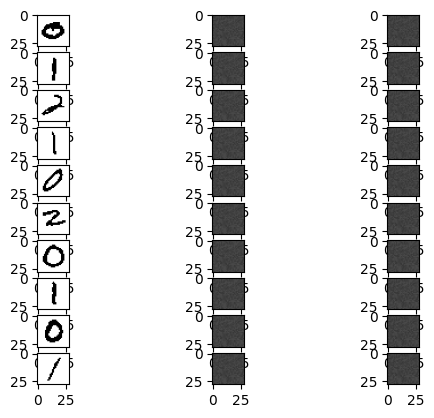

In [ ]:
b = 1
for img in training_data:
  x = img.reshape((1,-1))
  plt.subplot(10,3,(3*b)-2)
  plt.imshow(img.reshape((28,28)).detach().numpy(), vmin=-1, vmax=1, cmap='gray_r')
  b+=1


i = 1
for img in network(training_data):
  x = img.reshape((1,-1))
  plt.subplot(10,3,(3*i)-1)
  plt.imshow(img.reshape((28,28)).detach().numpy(), vmin=-1, vmax=1, cmap='gray_r')
  i+=1


j = 1
for img in network(testing_data):
  x = img.reshape((1,-1))
  plt.subplot(10,3,3*j)
  plt.imshow(img.reshape((28,28)).detach().numpy(), vmin=-1, vmax=1, cmap='gray_r')
  j+=1


In [ ]:
#Collection of data of training and testing accuracies
lr = 1e-4

hid = 1
Iteration 1 Training loss: 0.23460034
Iteration 1 Testing accuracy: 0.23400736
Iteration 2 Training loss: 0.22005859
Iteration 2 Testing accuracy: 0.21926661
Iteration 3 Training loss: 0.20169406
Iteration 3 Testing accuracy: 0.20092387
Iteration 4 Training loss: 0.18454152
Iteration 4 Testing accuracy: 0.18395677
Iteration 5 Training loss: 0.17019987
Iteration 5 Testing accuracy: 0.16975085
Iteration 6 Training loss: 0.15774094
Iteration 6 Testing accuracy: 0.15738954
Iteration 7 Training loss: 0.14670348
Iteration 7 Testing accuracy: 0.1464324
Iteration 8 Training loss: 0.13686612
Iteration 8 Testing accuracy: 0.13666414
Iteration 9 Training loss: 0.12809326
Iteration 9 Testing accuracy: 0.12795214
Iteration 10 Training loss: 0.12028408
Iteration 10 Testing accuracy: 0.12019638

hid = 2
Iteration 1 Training loss: 0.22434078
Iteration 1 Testing accuracy: 0.22324257
Iteration 2 Training loss: 0.19514844
Iteration 2 Testing accuracy: 0.19390093
Iteration 3 Training loss: 0.17079467
Iteration 3 Testing accuracy: 0.16994944
Iteration 4 Training loss: 0.15193044
Iteration 4 Testing accuracy: 0.1513172
Iteration 5 Training loss: 0.13658866
Iteration 5 Testing accuracy: 0.13614163
Iteration 6 Training loss: 0.12394652
Iteration 6 Testing accuracy: 0.12363074
Iteration 7 Training loss: 0.11350683
Iteration 7 Testing accuracy: 0.11329861
Iteration 8 Training loss: 0.104901
Iteration 8 Testing accuracy: 0.104781784
Iteration 9 Training loss: 0.09782826
Iteration 9 Testing accuracy: 0.0977817
Iteration 10 Training loss: 0.09203432
Iteration 10 Testing accuracy: 0.092046455

hid = 10
Iteration 1 Training loss: 0.15982457
Iteration 1 Testing accuracy: 0.15608738
Iteration 2 Training loss: 0.106663294
Iteration 2 Testing accuracy: 0.10542216
Iteration 3 Training loss: 0.086878456
Iteration 3 Testing accuracy: 0.086555764
Iteration 4 Training loss: 0.07823856
Iteration 4 Testing accuracy: 0.0782249
Iteration 5 Training loss: 0.07389428
Iteration 5 Testing accuracy: 0.07400333
Iteration 6 Training loss: 0.071485035
Iteration 6 Testing accuracy: 0.07164886
Iteration 7 Training loss: 0.07005094
Iteration 7 Testing accuracy: 0.07024105
Iteration 8 Training loss: 0.069151945
Iteration 8 Testing accuracy: 0.06935545
Iteration 9 Training loss: 0.06856659
Iteration 9 Testing accuracy: 0.068776324
Iteration 10 Training loss: 0.06817459
Iteration 10 Testing accuracy: 0.06838932


hid = 100
Iteration 1 Training loss: 0.07031588
Iteration 1 Testing accuracy: 0.07016995
Iteration 2 Training loss: 0.06667127
Iteration 2 Testing accuracy: 0.066664174
Iteration 3 Training loss: 0.061718874
Iteration 3 Testing accuracy: 0.06141702
Iteration 4 Training loss: 0.05532864
Iteration 4 Testing accuracy: 0.05491516
Iteration 5 Training loss: 0.049828764
Iteration 5 Testing accuracy: 0.049399372
Iteration 6 Training loss: 0.045025807
Iteration 6 Testing accuracy: 0.04456854
Iteration 7 Training loss: 0.040715035
Iteration 7 Testing accuracy: 0.040233392
Iteration 8 Training loss: 0.036859106
Iteration 8 Testing accuracy: 0.0363805
Iteration 9 Training loss: 0.033377815
Iteration 9 Testing accuracy: 0.032912422
Iteration 10 Training loss: 0.030312505
Iteration 10 Testing accuracy: 0.029870912

hid - 500
Iteration 1 Training loss: 0.052437164
Iteration 1 Testing accuracy: 0.05086624
Iteration 2 Training loss: 0.03512949
Iteration 2 Testing accuracy: 0.034176968
Iteration 3 Training loss: 0.025768813
Iteration 3 Testing accuracy: 0.025003448
Iteration 4 Training loss: 0.019492177
Iteration 4 Testing accuracy: 0.01883714
Iteration 5 Training loss: 0.015045383
Iteration 5 Testing accuracy: 0.01449202
Iteration 6 Training loss: 0.011880054
Iteration 6 Testing accuracy: 0.011417972
Iteration 7 Training loss: 0.00956976
Iteration 7 Testing accuracy: 0.009190487
Iteration 8 Training loss: 0.007848342
Iteration 8 Testing accuracy: 0.0075389156
Iteration 9 Training loss: 0.0065447036
Iteration 9 Testing accuracy: 0.0062954733
Iteration 10 Training loss: 0.005544732
Iteration 10 Testing accuracy: 0.0053452714

hid = 780
Iteration 1 Training loss: 0.044127576
Iteration 1 Testing accuracy: 0.04259138
Iteration 2 Training loss: 0.028108718
Iteration 2 Testing accuracy: 0.02717783
Iteration 3 Training loss: 0.019539006
Iteration 3 Testing accuracy: 0.018816855
Iteration 4 Training loss: 0.014222554
Iteration 4 Testing accuracy: 0.013657438
Iteration 5 Training loss: 0.010771147
Iteration 5 Testing accuracy: 0.010323426
Iteration 6 Training loss: 0.008404954
Iteration 6 Testing accuracy: 0.008053449
Iteration 7 Training loss: 0.006725972
Iteration 7 Testing accuracy: 0.006449663
Iteration 8 Training loss: 0.005503383
Iteration 8 Testing accuracy: 0.0052868645
Iteration 9 Training loss: 0.0045970166
Iteration 9 Testing accuracy: 0.0044310703
Iteration 10 Training loss: 0.003907098
Iteration 10 Testing accuracy: 0.0037795797

num_hid_neurons = [2,10,100,500,780]
training_losses = [0.09203432,0.06817459,0.030312505,0.005544732,0.003907098]

testing_losses = [0.092046455,0.06838932, 0.029870912,0.0053452714,0.0037795797]




SyntaxError: invalid syntax (<ipython-input-236-4b7088a54b80>, line 4)

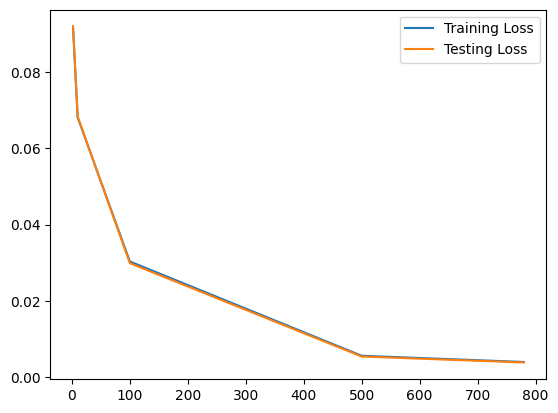

In [ ]:
num_hid_neurons = [2,10,100,500,780]
training_losses = [0.09203432,0.06817459,0.030312505,0.005544732,0.003907098]

testing_losses = [0.092046455,0.06838932, 0.029870912,0.0053452714,0.0037795797]


plt.figure()
plt.plot(num_hid_neurons, training_losses, label = 'Training Loss')

plt.plot(num_hid_neurons, testing_losses, label = 'Testing Loss')
plt.legend()

**3.2 [1 Mark]** Described what you've observed about the results of the autoencoder, compared to the Hopfield networks.

Autoencoder accuracy for training and testing is much lower than compared to that of Hopfield networks. Autoencoders, using backpropogation and the need for at least 1 hidden neural network while Hopfield networks, being bidirectionally connected with symmetrical weights don't use any hidden layers and learn steps in a single step (rather than updating the weights the way autoencoders do). Autoencoders also converge to their final weights much more rapidly than Hopfield networks.

**3.3 [1 Marks]** Sensory Preconditioning - Now we are going to look at small datasets. We are going to use the sensory preconditioning protocol, discussed by Gluck and Meyers.

We will also need to construct a data set that performs the preconditioning.  We will break this down into three phases:

1. Do the sensory preconditioning.  Plot the training loss vs number of epochs, describe the resultant behaviour.

In [ ]:
# Phase 1: Train the network
## features: s1, s2, context1, context2
# we are teaching this network that these inputs only occur to gether, regardless of the context.
stimuli = np.array([[0,0,0,0],
                    [0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,1,0,0],
                    [1,1,0,0],
                    [1,1,1,0],
                    [1,1,0,1],
                    [1,1,1,1]]).astype(np.float32)

dataset = TensorDataset(torch.from_numpy(stimuli), torch.from_numpy(stimuli))
data_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


epochs = 2000
outputs = []
losses = []

model = Autoencoder(4,3)# Your code here

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
loss_function = torch.nn.BCELoss()


for epoch in range(epochs):
    for (inp, out) in data_loader:

        # Output of Autoencoder
        reconstructed = model(inp)

        # Calculating the loss function
        loss = loss_function(reconstructed, out)

        # The gradients are set to zero,
        # the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting
        losses.append(loss.detach().numpy())
        pass
    outputs.append((epochs, inp, reconstructed))
    pass

0.67593867


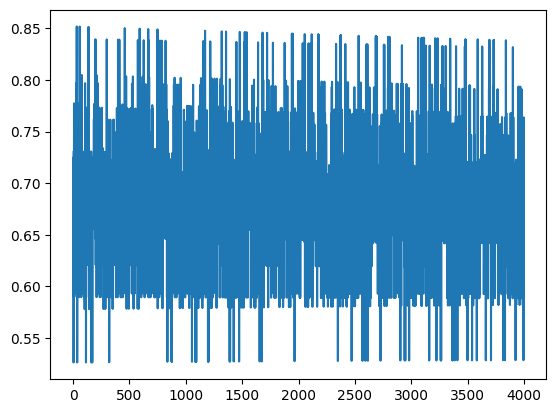

In [ ]:
# Plot loss performance.
# Your code here
print(losses[0])
plt.figure()
plt.plot(range(len(losses)), losses)




2. Train the conditioned response to one stimulus.  We will train this using simple linear regression where we map the the hidden state to the desired output.  You can reuse the linear regression code (```pseudo_inv```) from above.

You will be learning a mapping from the hidden state of the autoencoder to the conditioning stimuli.

Lets call the features (columns) of the stimuli data as s1, s2, c1, and c2.

In [ ]:

conditioning_stimuli = torch.from_numpy(np.array([[0,0,0,0],
                    [0,0,1,0],
                    [0,0,0,1],
                    [0,0,1,1],
                    [1,0,0,0],
                    [1,0,1,0],
                    [1,0,0,1],
                    [1,0,1,1]]).astype(np.float32))
conditioning_outputs = torch.from_numpy(np.array([[0,0,0,0,1,1,1,1]]).astype(np.float32).T)

conditioning_features = model.encoder(conditioning_stimuli)

def get_weights(features, values, lamb=0.01):
    return pseudo_inv(features.T, values)

def evaluate(weights, features):
    return pseudoinverse_hopfield_matrix(features)

W = get_weights(conditioning_features, conditioning_outputs)
conditioned_response = evaluate(W, conditioning_features[4:,:])

3. Report the strength of the conditioned response to the other stimulus.  Has the network transferred learning from one stimuls to the other?

In [ ]:
test_stimuli = torch.from_numpy(np.array([
                    [0,1,0,0],
                    [0,1,1,0],
                    [0,1,0,1],
                    [0,1,1,1]]).astype(np.float32))

testing_features = model.encoder(test_stimuli)

transferred_response = evaluate(W, testing_features)
print(transferred_response)

tensor([[0.1767, 0.0058, 0.0691],
        [0.0058, 0.1776, 0.0530],
        [0.0691, 0.0530, 0.1353]], grad_fn=<DivBackward0>)


4. Compare to the response of the system without either of the preconditioned inputs

In [ ]:
unconditioned_responses = evaluate(W, conditioning_features[:4,:])

In [ ]:
print(unconditioned_responses)

tensor([[0.1835, 0.0224, 0.0505],
        [0.0224, 0.1911, 0.0465],
        [0.0505, 0.0465, 0.1303]], grad_fn=<DivBackward0>)


5. Plot graphs showing the strength of the response to the conditioned stimuli, the pre-conditioned stimuli, and the unconditioned stimuli
(*i.e.*, s1 = 0, s2 = 0, and context in $\{(0,0),(0,1),(1,0),(1,1)\}$)

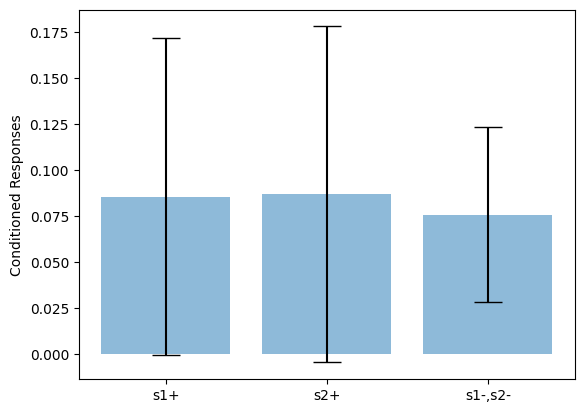

In [ ]:
response_mu = torch.mean(unconditioned_responses, axis=0) # Your code here
response_std = torch.std(unconditioned_responses, axis = 0) # your code here

fig,ax = plt.subplots()
ax.bar([1,2,3], response_mu.detach().numpy(), yerr=response_std.detach().numpy(), align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Conditioned Responses')
ax.set_xticks([1,2,3], labels=['s1+', 's2+', 's1-,s2-'])

**[BONUS]** [1 Mark] Repeat the sensory preconditioning, but use an conditioning stimulus that is not 100\% correlated with the unconditioned stimulus. That is: change phase 2 so that it is not possible to perfectly predict the output.